Best model: 1 features
Performance metrics:
 Number features                         1
CV folds PPV criteria               100.0
Sens val                 1.00 (0.97-1.00)
Spec val                 0.60 (0.40-0.75)
PPV val                  0.95 (0.93-0.97)
NPV val                  1.00 (0.50-1.00)
AUC val                  0.88 (0.78-0.94)
Name: 0, dtype: object

Selected features (percentage of folds selected):
Cyfra 21.1: 18.5%
proGRP: 81.5%


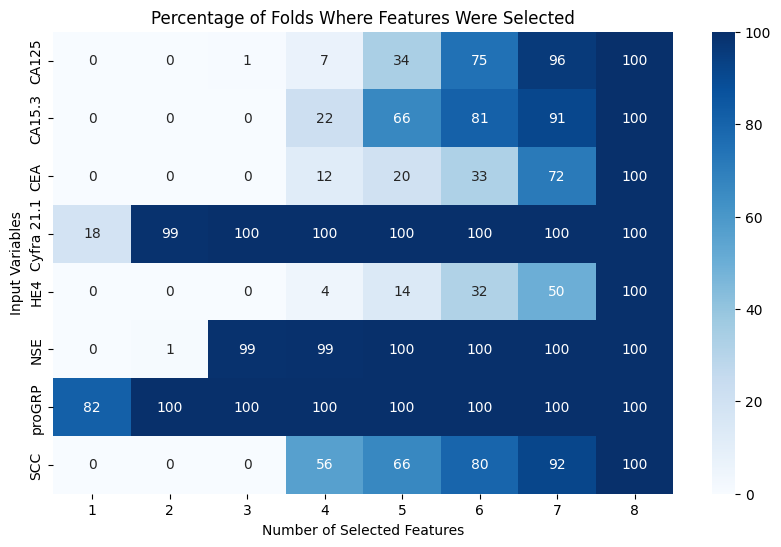

Heatmap saved to feature_selection_heatmap.png


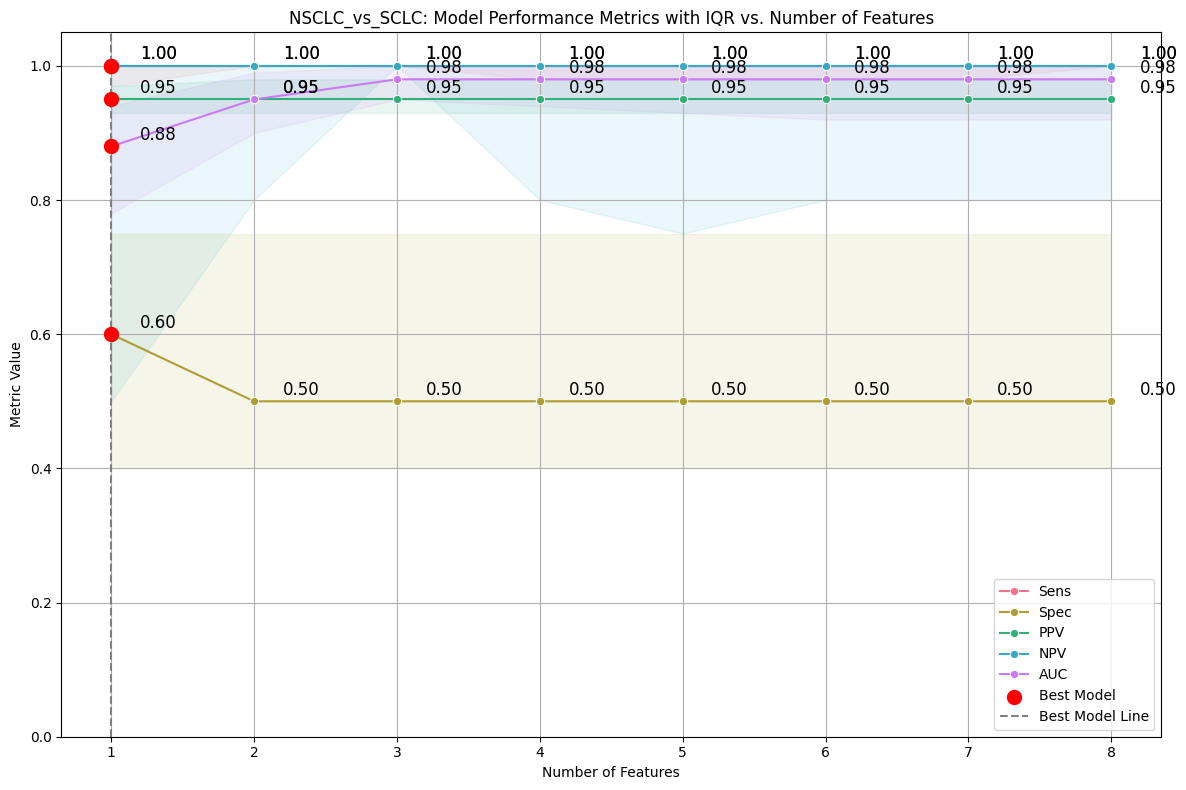

All metrics performance plot with IQR saved to all_metrics_performance_plot.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Define feature names (as used in the original code)
names_TMs = ['CA125', 'CA15.3', 'CEA', 'Cyfra 21.1', 'HE4', 'NSE', 'proGRP', 'SCC']

problem = 'NSCLC_vs_SCLC'  # Options: 'LC', 'NSCLC', 'SCLC'
if problem == 'LC':
    names_classes = ['No lung cancer', 'Primary lung carcinoma']
    ppv_aim = 0.98
elif problem == 'NSCLC':
    names_classes = ['No lung cancer + SCLC', 'NSCLC']
    ppv_aim = 0.95
elif problem == 'SCLC':
    names_classes = ['No lung cancer + NSCLC', 'SCLC']
    ppv_aim = 0.95
elif problem == 'NSCLC_vs_SCLC':
    names_classes = ['NSCLC', 'SCLC']
    ppv_aim = 0.95

pre = problem.lower()

# Function to parse median and IQR from string format "median (IQR_low-IQR_high)"
def parse_metric(metric_str):
    match = re.match(r"(\d+\.\d+)\s*\((\d+\.\d+)-(\d+\.\d+)\)", metric_str)
    if match:
        median = float(match.group(1))
        iqr_low = float(match.group(2))
        iqr_high = float(match.group(3))
        return median, iqr_low, iqr_high
    return np.nan, np.nan, np.nan

# Function to select the best model
def select_best_model(performance_metrics_table, cv_folds_threshold=80.0, ppv_min=0.98, sens_min=0.70):
    """
    Select the best model from performance_metrics_table.csv.
    Parameters:
    - performance_metrics_table: DataFrame with performance metrics
    - cv_folds_threshold: Minimum % of CV folds meeting PPV criteria
    - ppv_min: Minimum acceptable PPV
    - sens_min: Minimum acceptable sensitivity
    Returns:
    - best_n_features: Number of features for the best model
    - best_metrics: Metrics for the best model
    """
    # Parse median values for all metrics
    metrics = ['Sens val', 'Spec val', 'PPV val', 'NPV val', 'AUC val']
    for metric in metrics:
        performance_metrics_table[f'{metric}_median'] = performance_metrics_table[metric].apply(
            lambda x: parse_metric(x)[0]
        )

    # Filter models meeting CV folds, PPV, and sensitivity criteria
    valid_models = performance_metrics_table[
        (performance_metrics_table['CV folds PPV criteria'] >= cv_folds_threshold) &
        (performance_metrics_table['PPV val_median'] >= ppv_min) &
        (performance_metrics_table['Sens val_median'] >= sens_min)
    ]

    if valid_models.empty:
        print("No models meet the criteria: CV folds >= {:.1f}%, PPV >= {:.2f}, Sensitivity >= {:.2f}.".format(
            cv_folds_threshold, ppv_min, sens_min))
        return None, None

    # Sort by Sensitivity (descending) and Number of features (ascending)
    valid_models = valid_models.sort_values(
        by=['Sens val_median', 'Number features'], ascending=[False, True]
    )

    # Select the top model
    best_model = valid_models.iloc[0]
    best_n_features = int(best_model['Number features'])
    print("Best model: {} features".format(best_n_features))
    print("Performance metrics:\n", best_model[['Number features', 'CV folds PPV criteria', 
                                              'Sens val', 'Spec val', 'PPV val', 'NPV val', 'AUC val']])
    
    return best_n_features, best_model

# Load CSV files
try:
    performance_metrics_table = pd.read_csv(f"{pre}_performance_metrics_table.csv")
    selected_features_matrix = pd.read_csv(f"{pre}_selected_features_matrix.csv")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure CSV files are in the current directory.")
    exit()

# Convert selected_features_matrix to numpy array and assign column names
selected_features_matrix = selected_features_matrix.to_numpy()
n_features_to_select = performance_metrics_table['Number features'].values

best_n_features, best_metrics = select_best_model(
    performance_metrics_table,
    cv_folds_threshold=80.0,
    ppv_min=ppv_aim,
    sens_min=0
)

# If a best model is found, inspect selected features
if best_n_features is not None:
    idx = list(n_features_to_select).index(best_n_features)
    selected_features = selected_features_matrix[:, idx]
    print("\nSelected features (percentage of folds selected):")
    for feature, percentage in zip(names_TMs, selected_features):
        if percentage > 0:
            print(f"{feature}: {percentage:.1f}%")

    # Plot feature selection heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(selected_features_matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=n_features_to_select, yticklabels=names_TMs)
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Input Variables')
    plt.title('Percentage of Folds Where Features Were Selected')
    plt.savefig('feature_selection_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Heatmap saved to feature_selection_heatmap.png")

    # Parse all metrics for plotting
    metrics = ['Sens val', 'Spec val', 'PPV val', 'NPV val', 'AUC val']
    metric_medians = {}
    metric_iqr_low = {}
    metric_iqr_high = {}
    for metric in metrics:
        performance_metrics_table[f'{metric}_median'] = performance_metrics_table[metric].apply(
            lambda x: parse_metric(x)[0]
        )
        performance_metrics_table[f'{metric}_iqr_low'] = performance_metrics_table[metric].apply(
            lambda x: parse_metric(x)[1]
        )
        performance_metrics_table[f'{metric}_iqr_high'] = performance_metrics_table[metric].apply(
            lambda x: parse_metric(x)[2]
        )
        metric_medians[metric] = performance_metrics_table[f'{metric}_median']
        metric_iqr_low[metric] = performance_metrics_table[f'{metric}_iqr_low']
        metric_iqr_high[metric] = performance_metrics_table[f'{metric}_iqr_high']

    # Plot all performance metrics with IQR
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("husl", len(metrics))
    for i, metric in enumerate(metrics):
        sns.lineplot(
            data=performance_metrics_table,
            x='Number features',
            y=f'{metric}_median',
            label=metric  .replace(' val', ''),
            marker='o',
            color=colors[i]
        )
        plt.fill_between(
            performance_metrics_table['Number features'],
            metric_iqr_low[metric],
            metric_iqr_high[metric],
            color=colors[i],
            alpha=0.1
        )

    # Highlight best model
    for metric in metrics:
        plt.scatter(
            best_n_features,
            best_metrics[f'{metric}_median'],
            color='red',
            s=100,
            zorder=5,
            label='Best Model' if metric == metrics[0] else None
        )
        # Annotate points
        for _, row in performance_metrics_table.iterrows():
            x = row['Number features']
            y = row[f'{metric}_median']
            plt.text(x + 0.2, y + 0.01, f"{y:.2f}", color='black', fontsize=12)

    plt.axvline(x=best_n_features, color='gray', linestyle='--', label='Best Model Line')
    plt.xlabel('Number of Features')
    plt.ylabel('Metric Value')
    plt.title(f'{problem}: Model Performance Metrics with IQR vs. Number of Features')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('all_metrics_performance_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("All metrics performance plot with IQR saved to all_metrics_performance_plot.png")